In [1]:
!pip3 install datasets transformers -q

In [2]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from dataloaders import GoEmotionsSoft

In [3]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/Users/robertthomas/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train, valid, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

In [5]:
train_text = train["text"].tolist()
train_labels = train["labels"].tolist()
valid_text = valid["text"].tolist()
valid_labels = valid["labels"].tolist()

In [6]:
text = train_text+valid_text
labels = train_labels+valid_labels

In [7]:
text = pd.DataFrame(text)
text.rename({0: 'text'}, axis=1, inplace=True)
labels= pd.DataFrame(labels)
labels.rename({0: 'emotions'}, axis=1, inplace=True)

In [8]:
text.head()

,text
0,My favourite food is anything I didn't have to...
1,"Now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened
4,Dirty Southern Wankers


In [9]:
labels.head()

,emotions,1,2,3,4
0,27,NaN,NaN,NaN,NaN
1,27,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,14,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN


In [10]:
labels = labels.drop([1,2,3,4], axis=1)

In [11]:
data = pd.concat([text, labels], axis=1)

In [12]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [13]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [14]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [15]:
emotions=[]
for i in data.emotions:
    emotions.append(mapping[i])
  
data['emotions']=emotions

In [16]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,annoyance


In [17]:
max_len = 0
all_len=[]
for i in data.text:
    all_len.append(len(i))
    max_len=max(max_len,len(i))
print(max_len)    

703


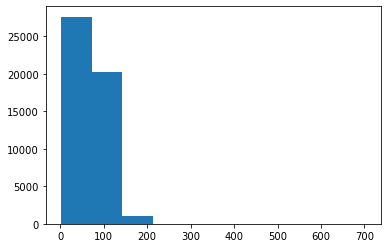

In [18]:
from matplotlib import pyplot as plt
plt.hist(all_len)
plt.show()

In [19]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [20]:
len(data.loc[0].text.split(' '))

11

In [21]:
len(data)

48836

In [22]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 200].copy()

In [23]:
data.head()

,text,emotions,token_size
0,My favourite food is anything I didn't have to...,neutral,11
1,"Now if he does off himself, everyone will thin...",neutral,20
2,WHY THE FUCK IS BAYLESS ISOING,anger,6
3,To make her feel threatened,fear,5
4,Dirty Southern Wankers,annoyance,3


In [24]:
data['token_size'].describe()

count    48836.000000
mean        12.897453
std          6.738225
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: token_size, dtype: float64

In [25]:
inputs = ConstructVocab(data["text"].values.tolist())

In [26]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [27]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [28]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

33


In [29]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [30]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [31]:
input_tensor[0:2]

[array([12922, 32633, 33405, 38438, 21180, 10602, 29323, 35848, 56020,
        27258, 42732,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([13396, 37260, 35892, 29964, 43860, 36389, 31702, 59248, 55556,
        36259, 35867, 19663, 39519, 50661, 59396, 45403, 38058, 43847,
        20033, 28465,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])]

In [32]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [33]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0]])

In [34]:
data[0:2]

,text,emotions,token_size
0,My favourite food is anything I didn't have to...,neutral,11
1,"Now if he does off himself, everyone will thin...",neutral,20


In [35]:
get_emotion = lambda t: np.argmax(t)

In [36]:
get_emotion(target_tensor[0])

20

In [37]:
emotion_dict=mapping
emotion_dict[get_emotion(target_tensor[0])]

'optimism'

In [61]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(input_tensor_train[0].dtype)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

int64


(39068, 39068, 4884, 4884, 4884, 4884)

In [62]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [63]:
from torch.utils.data import Dataset, DataLoader

In [64]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [65]:
train_logits = torch.zeros((50000, n_labels))

train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [66]:
val_loader.batch_size

64

In [67]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [68]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths, logits):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    logits = logits[indx]
    return X.transpose(0,1), y, lengths, logits # transpose (batch x seq) to (seq x batch)

In [69]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
# model.to(device)

# # obtain one sample from the data iterator
# it = iter(train_dataset)
# x, y, x_len, logits = next(it)

# # sort the batch first to be able to use with pac_pack sequence
# xs, ys, lens, logits = sort_batch(x, y, x_len, logits)

# print("Input size: ", xs.size())

# output, _ = model(xs.to(device), lens, device)
# print(output.size())

In [70]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [105]:
def train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits):
    model.train()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()
    
    for idx, (image, labels, lens, softlabel, index) in enumerate(train_loader):
        image = image.float()
        if torch.cuda.is_available():
            image = image.cuda()
            labels = labels.cuda()
        image = image.int()
        output, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = output
        loss = criterion(output, labels.argmax(dim=1))
        acc1 = accuracy(output, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1.item(), image.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return top1.avg, losses.avg, train_logits




def train_lwr(epoch, train_loader, model, criterion_list, optimizer, options, train_logits):
    model.train()
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()

    criterion_cls = criterion_list[0]
    critetion_soft = criterion_list[1]
    criterion_kl = criterion_list[2]

    losses = AverageMeter()
    top1 = AverageMeter()

    
    for idx, data in enumerate(train_loader):
        image, labels, lens, logits, index = data
        image = image.float()
        if torch.cuda.is_available():
            image = image.cuda().int()
            labels = labels.cuda()
            logits = logits.cuda()
        
        soft_label = critetion_soft(logits)        
        preact = False
        logit_s, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = logit_s
        loss_cls = criterion_cls(logit_s, labels.argmax(dim=1))        
        loss_kl = criterion_kl(logit_s, soft_label)

        if epoch<=options["k"]:
            loss = loss_cls 
        else:
            num_5 = int(epoch/options["k"])
            cure = num_5*options["k"]
            
            loss = (options["gamma"]+(1-cure/240)*(1-options["gamma"])) * loss_cls + cure/240*(1-options["gamma"])* loss_kl

        acc1 = accuracy(logit_s, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1[0], image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return top1.avg, losses.avg, train_logits

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def validate(val_loader, model, criterion, options):
    
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    with torch.no_grad():
        
        for idx, (image, label, lens) in enumerate(val_loader):

            image = image.float()
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()

            output, _ = model(image.permute(1 ,0).to(device), lens, device)
            loss = criterion(output, label)
            acc1 = accuracy(output, label)
            losses.update(loss.item(), image.size(0))
            top1.update(acc1[0], image.size(0))
            
    return top1.avg,losses.avg


In [106]:
options = {
    "epochs": 20,
    "arch": "EmoGRU",
    "k": 5,
    "gamma": 0.9
}

best_acc = 0
for epoch in range(1, int(options["epochs"])+ 1):

        if epoch<=options["k"]:
            train_acc, train_loss, train_logits= train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits)
        else:
            train_acc, train_loss, train_logits= train_lwr(epoch, train_loader, model, criterion, optimizer, options, train_logits)
         
        
        train_logits = train_logits.detach().cpu()
            
        if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                                drop_last=True,
                                shuffle=True)
        
        print('epoch {}'.format(epoch))


        test_acc, test_loss = validate(val_loader, model, criterion, options)

        print("Current Test Accuracy:",test_acc)
        # calculate best accuracy.
        if test_acc > best_acc:
            best_acc = test_acc
        
        print('best accuracy:', best_acc)


KeyboardInterrupt: 

In [ ]:
model.parameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

In [ ]:
model.load_state_dict(torch.load("/content/model.pth"))
model.eval()

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

#device = "cuda" # we don't need GPU to do testing
model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

In [ ]:
torch.save(model.state_dict(), "/content/model.pth")